In [81]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

import pickle
import os
import sys
import glob
from collections import OrderedDict
from tqdm import tqdm

In [82]:
sys.path.append('../../')
import compute_preprocessing

In [83]:
def convert_input_for_ann(times, q, chi1, theta1):
    X = []
    for _q, _chi1, _theta1 in zip(q, chi1, theta1):
        for t in times:
            X.append([t, _q, _chi1, _theta1])
    X = np.asarray(X)
    return X

In [84]:
def compute_model_input(times, q, chi1, theta1):
    
    # broadcast and stack with times array
    output = np.ones(shape=(times.shape[0], 1))
    output = output * np.array([q, chi1, theta1])
    
    output = np.column_stack((times, output))
    
    return output

In [85]:
import tensorflow as tf

In [86]:
import pugna.layers
import pugna.activations

In [87]:
# https://datascience.stackexchange.com/questions/58884/how-to-create-custom-activation-functions-in-keras-tensorflow
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})

In [88]:
def preload_amp(data_dir):

    pkl_filename = os.path.join(data_dir, "pre_processing_1e3/times_scaler.pkl")
    with open(pkl_filename, 'rb') as file:
        times_scaler = pickle.load(file)
    
    
    times = np.load(os.path.join(data_dir, "training_data_1e3/times.npy"))
    
    times_scaled = times_scaler.transform(times[:, np.newaxis])[:, 0]
    
    ys_raw = np.load(os.path.join(data_dir, "training_data_1e3/amplitude.npy"))
    ys_processing_params = np.load(os.path.join(data_dir, "pre_processing_1e3/amp_preprocessing_params.npz"))
    
    ys = compute_preprocessing.apply_pre_process_forward(ys_raw, ys_processing_params['mean'], ys_processing_params['max'])
    
    coords = np.load(os.path.join(data_dir, "training_data_1e3/coords.npy"))
#     X = convert_input_for_ann(times_scaled, coords[0], coords[1], coords[2])

    

                     
    return times, times_scaled, coords, ys_raw, ys, ys_processing_params

# def preload_phase(data_dir):

#     pkl_filename = os.path.join(data_dir, "pre_processing_1e3/times_scaler.pkl")
#     with open(pkl_filename, 'rb') as file:
#         times_scaler = pickle.load(file)
    
    
#     times = np.load(os.path.join(data_dir, "training_data_1e3/times.npy"))
    
#     times_scaled = times_scaler.transform(times[:, np.newaxis])[:, 0]
    
#     ys_raw = np.load(os.path.join(data_dir, "training_data_1e3/phase.npy"))
#     ys_processing_params = np.load(os.path.join(data_dir, "pre_processing_1e3/phase_preprocessing_params.npz"))
    
#     ys = compute_preprocessing.apply_pre_process_forward(ys_raw, ys_processing_params['mean'], ys_processing_params['max'])
    
#     coords = np.load(os.path.join(data_dir, "training_data_1e3/coords.npy"))
# #     X = convert_input_for_ann(times_scaled, coords[0], coords[1], coords[2])

    

                     
#     return times, times_scaled, coords, ys_raw, ys, ys_processing_params

In [89]:
mfiles = sorted(glob.glob("00*/model*"))
print(mfiles)

models = OrderedDict()
for mfile in mfiles:
    key = mfile.split('/')[0]
    models[key] = tf.keras.models.load_model(mfile,
                                       custom_objects={'Mscale': pugna.layers.Mscale,
                                                       'Activation':tf.keras.layers.Activation,
                                                       'name':pugna.activations.s2relu})

['001/model.h5', '002/model.h5', '003/model.h5', '004/model.h5']


In [90]:
models.keys()

odict_keys(['001', '002', '003', '004'])

In [91]:
data_dir="/home/sebastian.khan/git/stk/ml/waveforms/april2021/3d-precession/upscale/"

In [92]:
times, times_scaled, coords, ys_raw, ys, ys_processing_params = preload_amp(data_dir=data_dir)
# times, times_scaled, coords, ys_raw, ys, ys_processing_params = preload_phase(data_dir=data_dir)

In [93]:
coords.shape

(3, 1000)

In [94]:
ys.shape

(1000, 1099)

In [95]:
times

array([-499.50529851, -499.00529851, -498.50529851, ...,   48.49470149,
         48.99470149,   49.49470149])

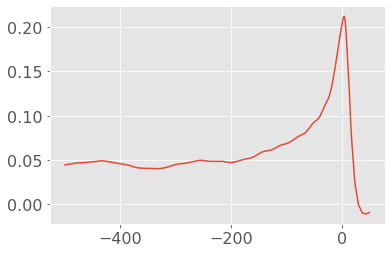

In [96]:
plt.figure()
plt.plot(times, ys[0])

In [97]:
def compare_models(index, ys_raw, preprocessing_params, coords, times_scaled, times, models, ylim=None, xlim=None):
    q = np.around(coords[0,index], 3)
    chi1 = np.around(coords[1,index], 3)
    theta1 = np.around(coords[2,index], 3)
    
    title = f"q = {q}, chi1 = {chi1}, theta1 = {theta1}"
    
    Xhat = compute_model_input(times_scaled, q, chi1, theta1)
    yhats = OrderedDict()
    for k, v in models.items():
        yhat = models[k].predict(Xhat).T
        
        yhats[k] = compute_preprocessing.apply_pre_process_reverse(yhat, preprocessing_params['mean'], preprocessing_params['max'])[0]
#         yhats[k] = yhat[0]
        
        
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    plt.plot(times, ys_raw[index], label='data')
    for k, v in yhats.items():
        plt.plot(times, v, label=k, ls='--')
    if xlim:
        plt.xlim(*xlim)
#     plt.xlim(-200, 50)
#     plt.xlim(-10, 50)
#     plt.yscale('log')
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.subplot(2, 1, 2)
    for k, v in yhats.items():
#         plt.plot(times, 100*np.abs((v-ys_raw[index])/ys_raw[index]), label=f"% (data-{k})")
        plt.plot(times, (v-ys_raw[index]), label=f"% (data-{k})")
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)
#     plt.xlim(-200, 50)
#     plt.xlim(-10, 50)
#     plt.ylim(-10, 10)
#     plt.yscale('log')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [98]:
np.where((coords[1] > 0.98) & (coords[2] > 1.3))

(array([ 73,  78, 754]),)

In [99]:
np.where((coords[1] > 0.6) & (coords[2] > 1.3) & (coords[2] < 1.6))

(array([ 25,  46,  63,  65,  98, 102, 104, 119, 123, 124, 175, 192, 193,
        194, 210, 222, 229, 233, 252, 266, 275, 304, 320, 360, 395, 411,
        422, 433, 449, 460, 476, 488, 493, 502, 538, 542, 545, 566, 568,
        570, 646, 659, 661, 684, 685, 745, 754, 767, 771, 788, 810, 836,
        840, 852, 891, 948, 970]),)

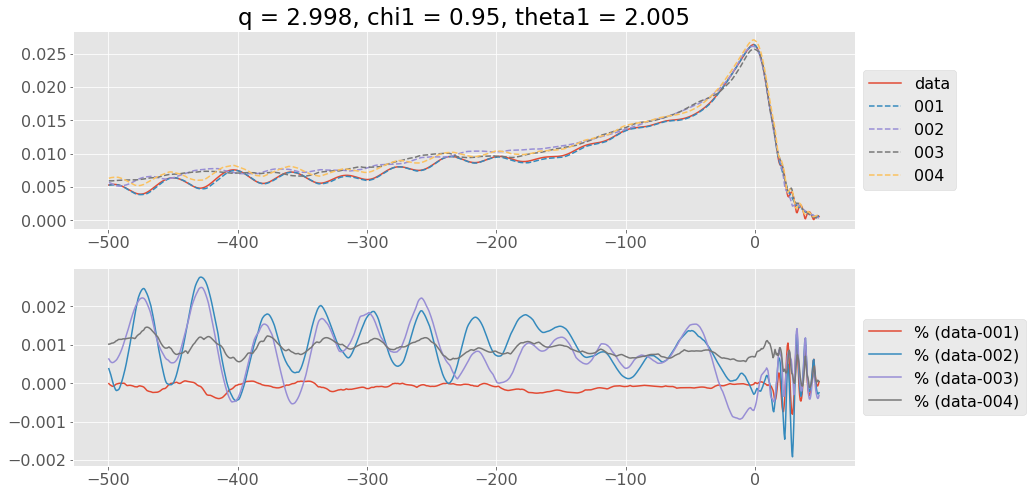

In [100]:
# compare_models(index=789, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, ylim=(-0.1,0.1))
compare_models(index=789, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

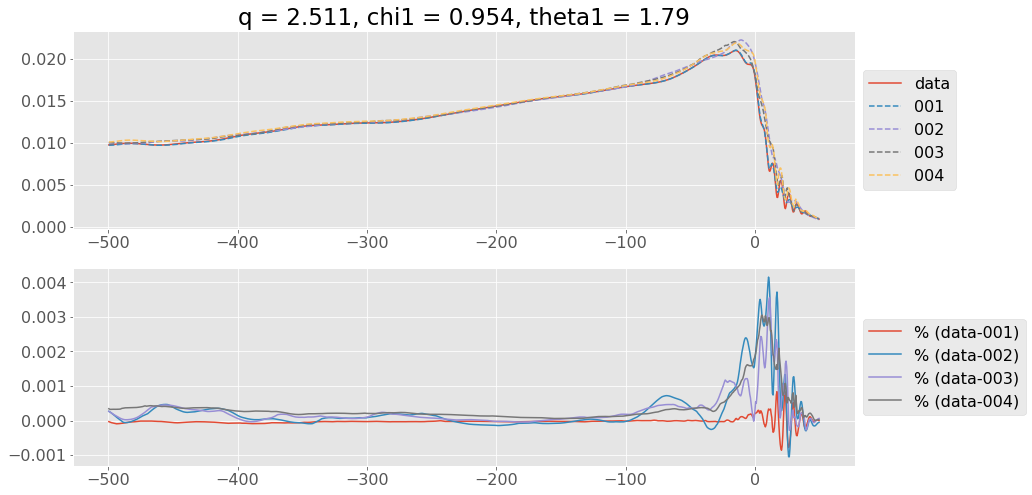

In [101]:
# compare_models(index=10, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, ylim=(-0.1,0.1))
compare_models(index=10, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

In [102]:
# compare_models(index=361, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, ylim=(-0.1,0.1))
# compare_models(index=361, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models={'005':models['005']})

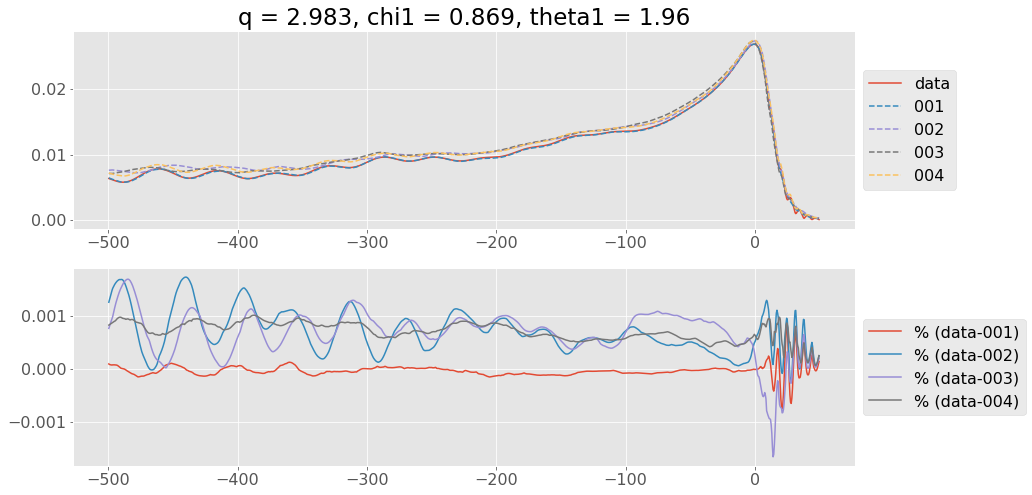

In [103]:
# compare_models(index=82, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, ylim=(-0.1,0.1))
compare_models(index=82, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

In [104]:
# Xhat = convert_input_for_ann(times_scaled, *coords[:, :10])
# # Xhat = convert_input_for_ann(times_scaled, *coords)
# yhat = models['008'].predict(Xhat).T

In [105]:
# yhat.shape

In [106]:
def compute_errors(ys_raw, preprocessing_params, coords, times_scaled, times, models):
    
    n_cases = coords.shape[1]
#     max_loop = 10
    max_loop = n_cases
    
    yhats = OrderedDict()
    errors = OrderedDict()
    for k, v in models.items():
        
        if os.path.exists(f"errors_{k}.npy"):
            print("ALREADY CALCULATED LOADING DATA")
            errors[k] = np.load(f"errors_{k}.npy")
            continue
        
        print(f"working model: {k}")
        yhats[k] = np.zeros(shape=(n_cases, times_scaled.shape[0]))
        errors[k] = np.zeros(shape=(max_loop))

#         for index in tqdm(range(n_cases)):
        for index in tqdm(range(max_loop)):

            q = coords[0,index]
            chi1 = coords[1,index]
            theta1 = coords[2,index]

            Xhat = compute_model_input(times_scaled, q, chi1, theta1)
        
            yhat = models[k].predict(Xhat).T
            tt = compute_preprocessing.apply_pre_process_reverse(yhat, preprocessing_params['mean'], preprocessing_params['max'])[0]
            yhats[k][index] = tt
            
#             errors[k][index] = np.max(100*(ys_raw[index]-yhats[k][index])/ys_raw[index])
            errors[k][index] = np.max(np.abs(ys_raw[index]-yhats[k][index]))
            
        print("SAVING")
        np.save(f"errors_{k}.npy", errors[k])
        
    return errors

In [107]:
%%time
errors = compute_errors(ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

  0%|          | 0/1000 [00:00<?, ?it/s]

ALREADY CALCULATED LOADING DATA
ALREADY CALCULATED LOADING DATA
ALREADY CALCULATED LOADING DATA
working model: 004


100%|██████████| 1000/1000 [04:52<00:00,  3.42it/s]

SAVING
CPU times: user 14min 45s, sys: 1min 20s, total: 16min 6s
Wall time: 4min 52s


In [108]:
# errors['008'].shape

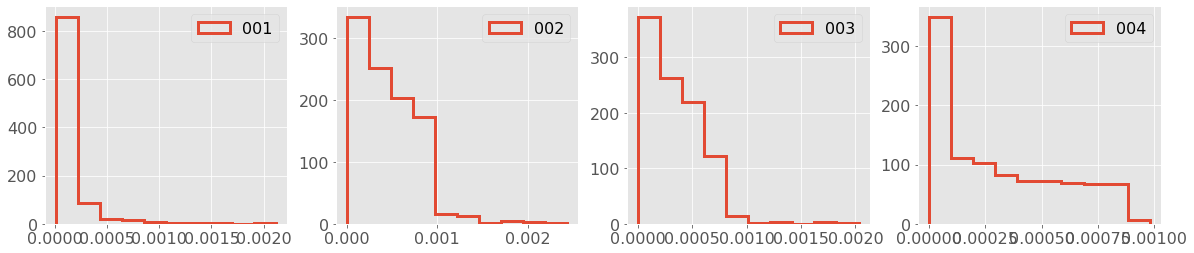

In [109]:
plt.figure(figsize=(20, 4))
for i,(k,v) in enumerate(errors.items()):
    plt.subplot(1, len(errors.keys()), i+1)
    plt.hist(np.abs(v), label=k, histtype='step', linewidth=3);
#     , density=True
    plt.legend()
# plt.xlim(0, 100)

In [110]:
max_idx = {}
for i,(k,v) in enumerate(errors.items()):
    max_value = np.max(np.abs(v))
    print(f"{k}: {max_value}")
    max_idx[k] = np.where(np.abs(v) == max_value)

001: 0.0021196741813749205
002: 0.002440152237800291
003: 0.0020285939309331452
004: 0.000978748209695915


In [111]:
max_idx

{'001': (array([252]),),
 '002': (array([712]),),
 '003': (array([252]),),
 '004': (array([888]),)}

Text(0, 0.5, '$\\theta_1$')

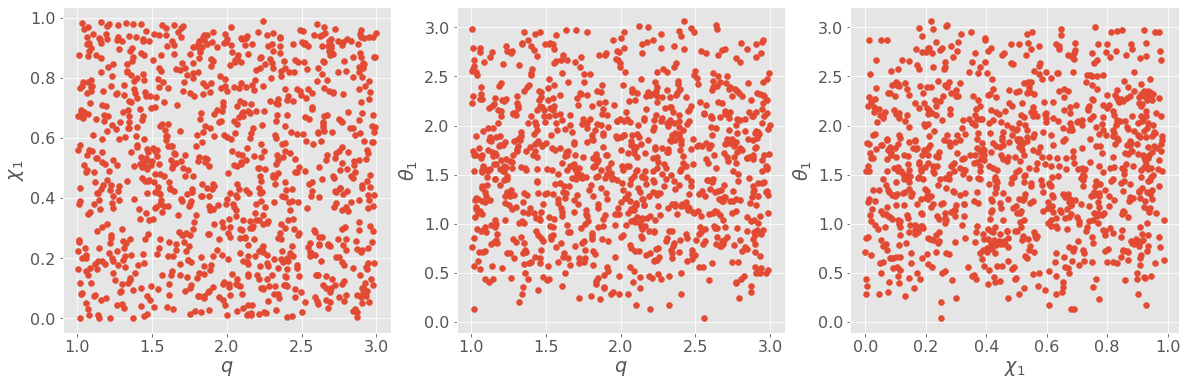

In [112]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0], coords[1])
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0], coords[2])
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1], coords[2])
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')

Text(0, 0.5, '$\\theta_1$')

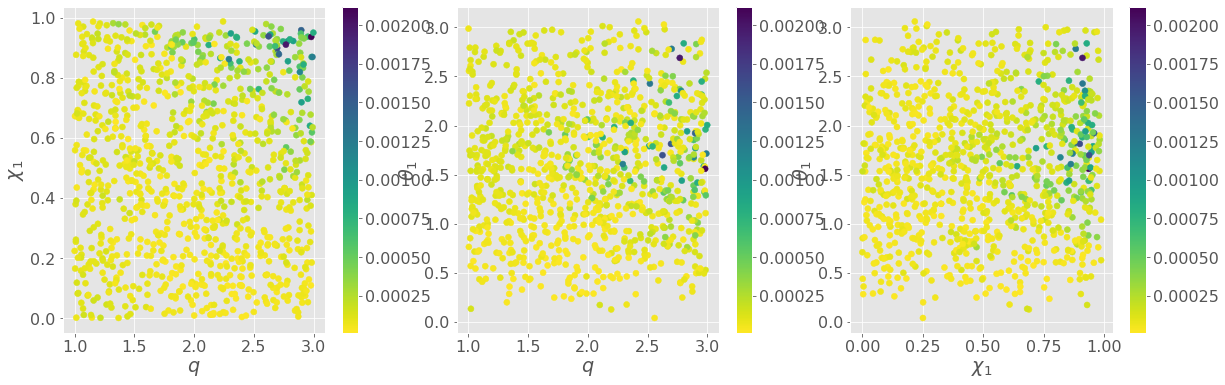

In [113]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0], coords[1], c=errors['001'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0], coords[2], c=errors['001'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1], coords[2], c=errors['001'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')

Text(0, 0.5, '$\\theta_1$')

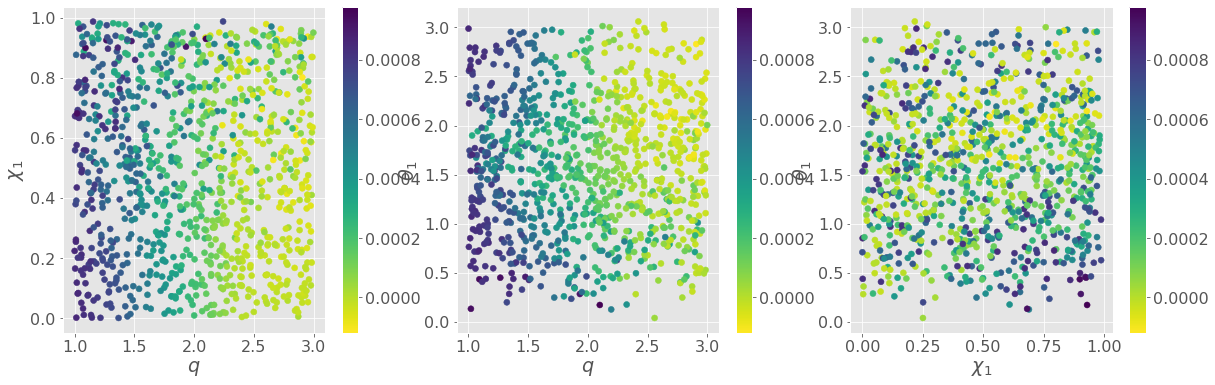

In [124]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0], coords[1], c=errors['004'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0], coords[2], c=errors['004'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1], coords[2], c=errors['004'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')

In [125]:
# worst_cases_values = np.flip(np.sort(np.abs(errors['004'])))[:10]
worst_cases_values = np.flip(np.sort(np.abs(errors['004'])))[-10:]
worst_cases_idx = np.array([np.where(np.abs(errors['004']) == w_c)[0][0] for w_c in worst_cases_values])

In [126]:
worst_cases_values

array([2.77791941e-06, 2.64889767e-06, 2.57888375e-06, 2.55004361e-06,
       2.54199239e-06, 2.44015835e-06, 2.40383943e-06, 1.35707940e-06,
       8.07065672e-07, 5.59736955e-07])

In [127]:
worst_cases_idx

array([280, 198, 696, 652, 680,   6, 809, 615, 983, 958])

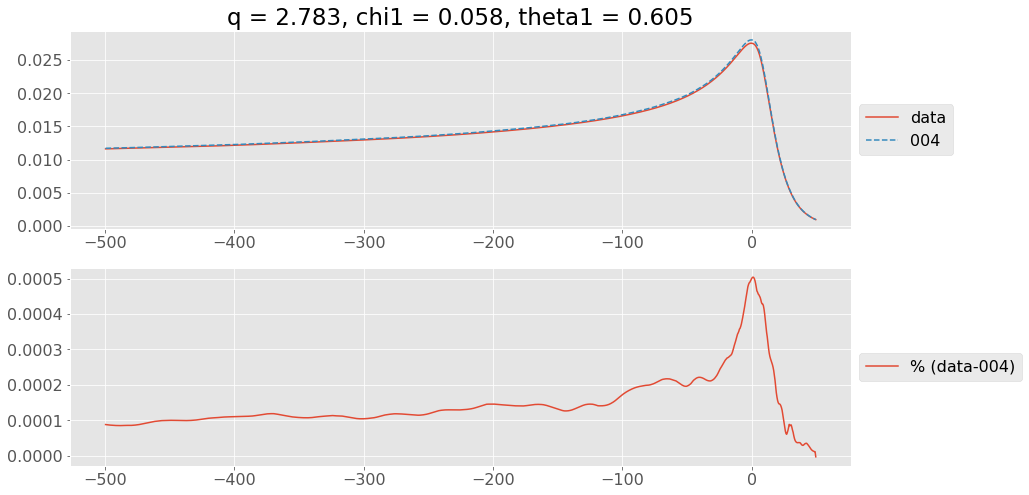

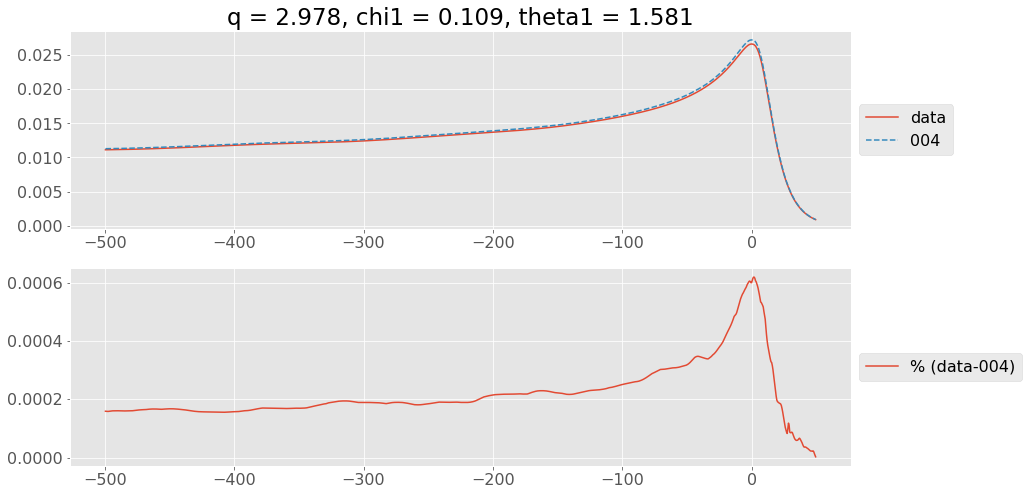

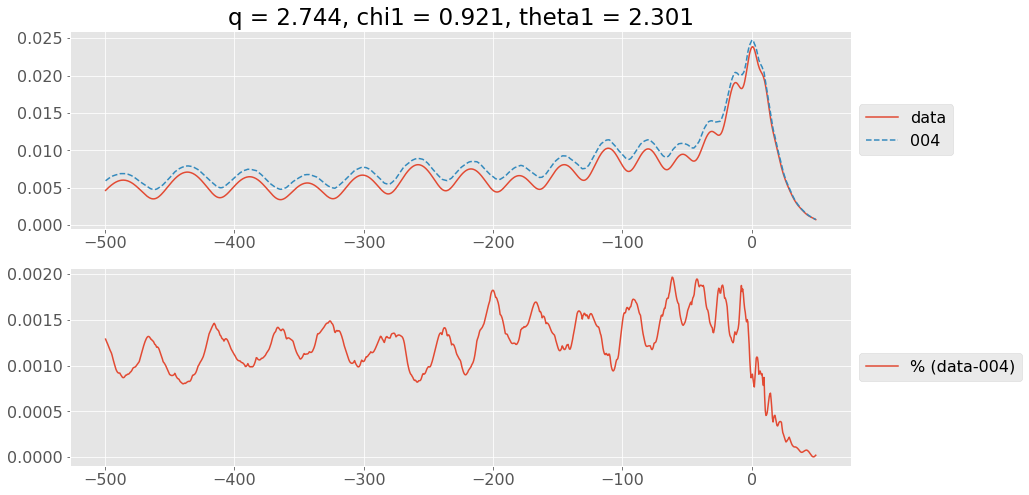

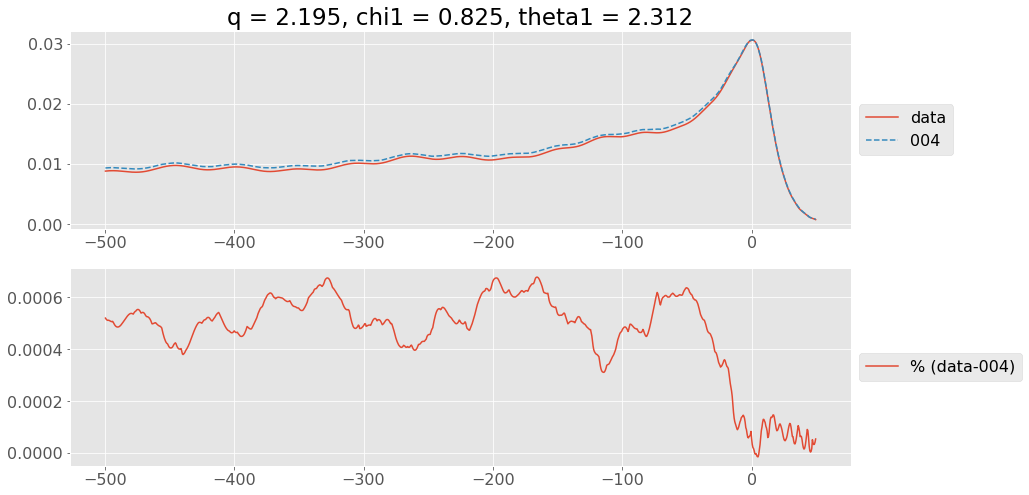

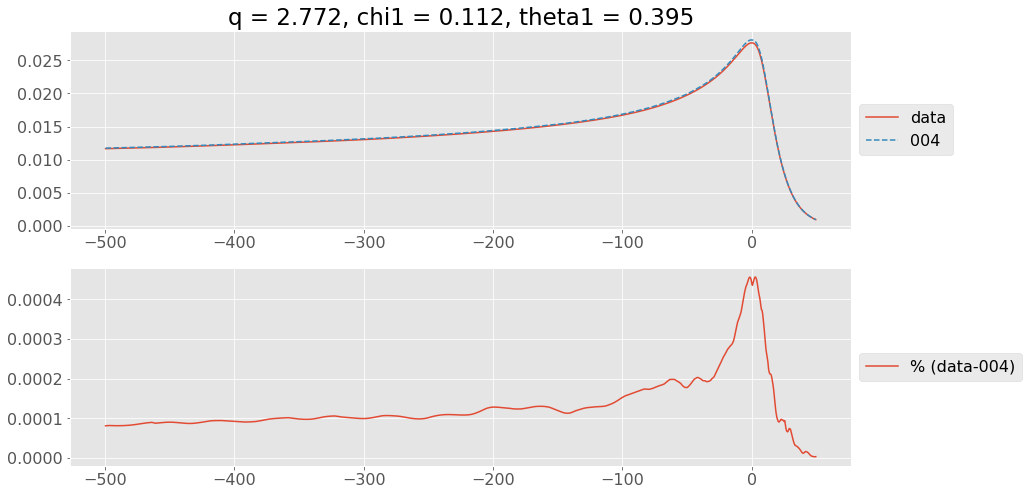

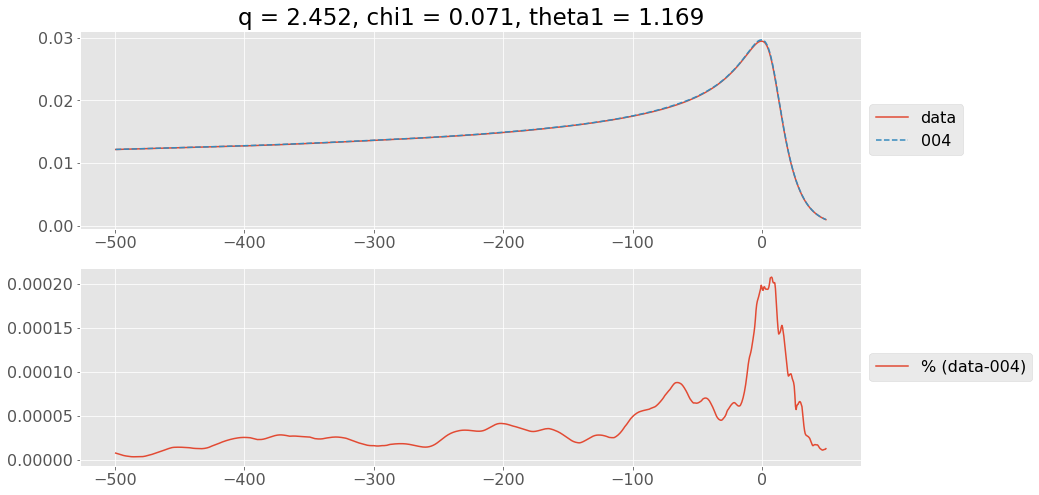

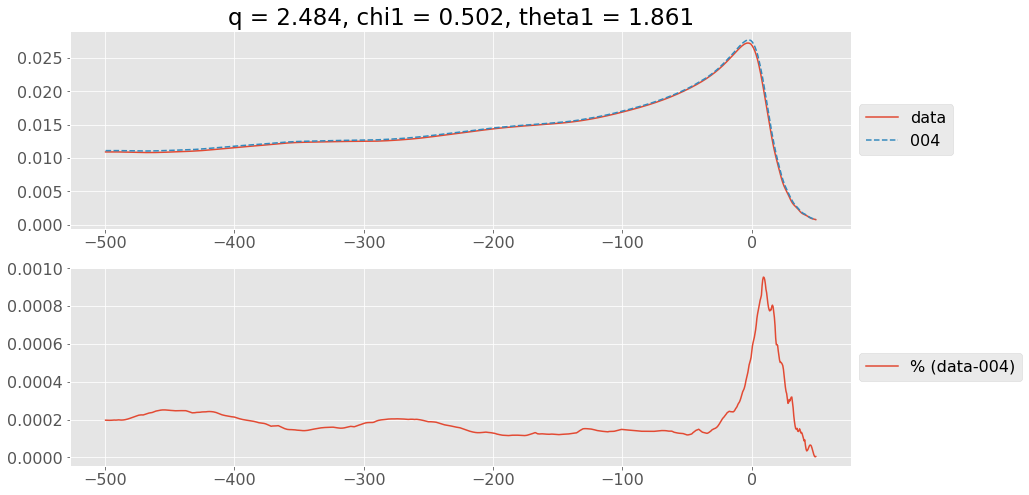

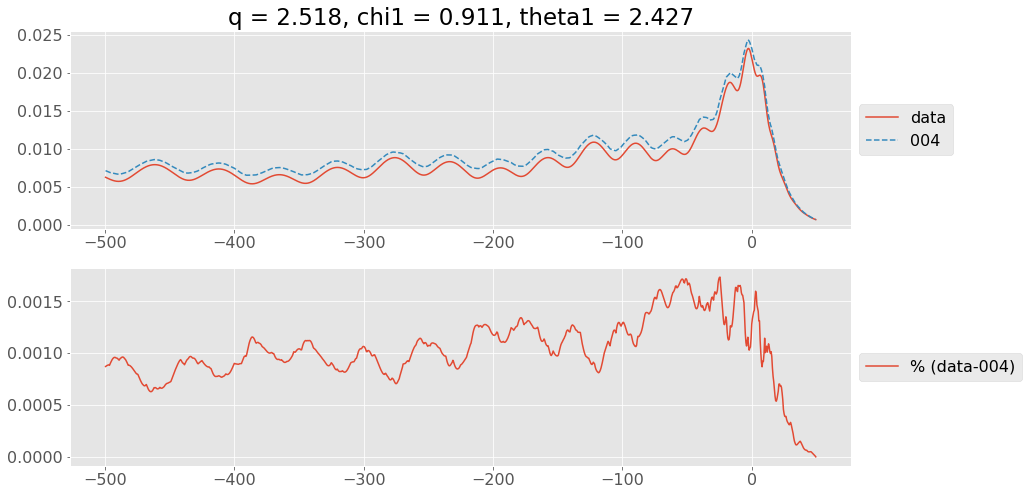

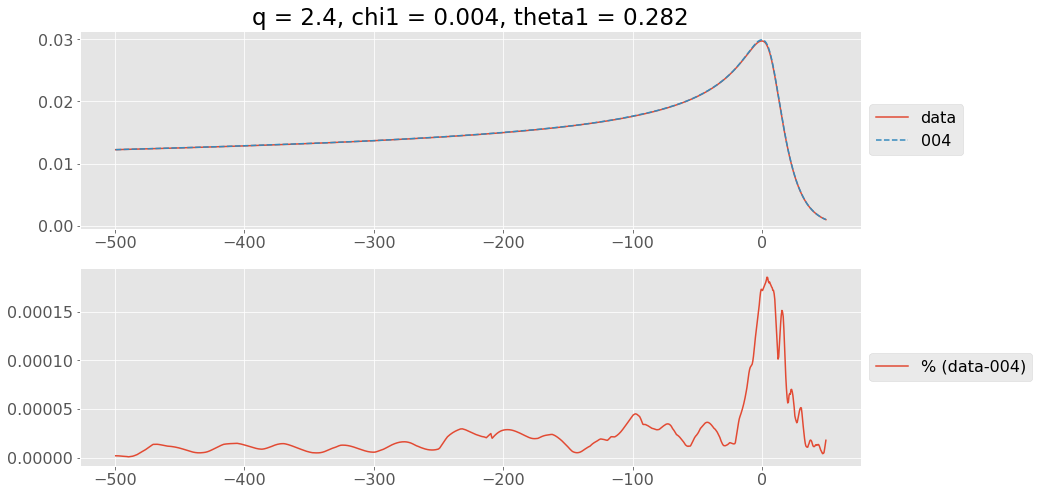

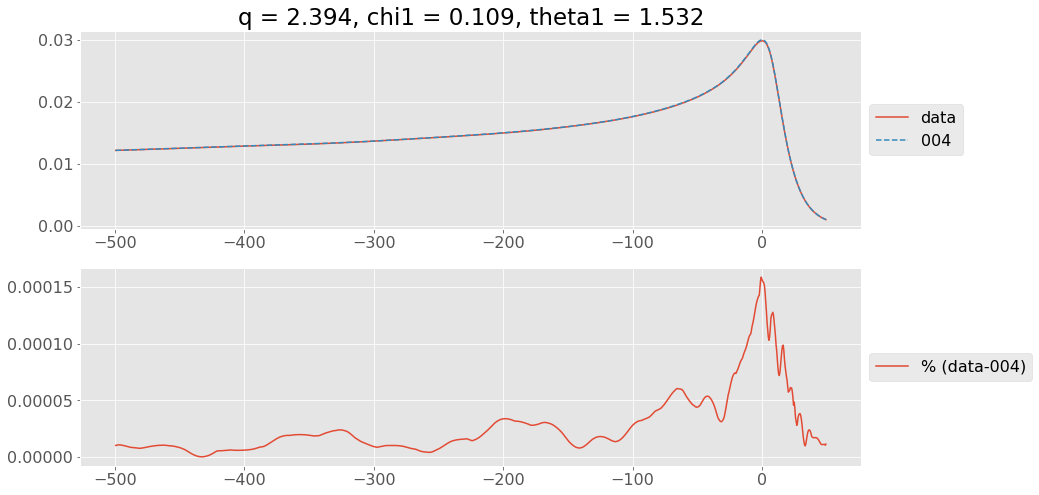

In [128]:
for index in worst_cases_idx:
    compare_models(index=index, ys_raw=ys_raw, preprocessing_params=ys_processing_params,
                   coords=coords, times_scaled=times_scaled, times=times, models={'004':models['004']})

In [118]:
# smaller time resolution to fix ringdown?
# (theta, phi) - sky angles?
#    - try just theta = pi/2?
# go to much larger q to check - e.g. 6
# try v4PHM